In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
import time
import random
import statistics as sts
from scipy.stats.mstats import gmean 
from scipy import stats

import tensorflow as tf
from tensorflow.keras import backend as Bkd
from tensorflow.keras.layers import Lambda

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Embedding, Dropout, Conv1D,Flatten, MaxPooling1D, Activation
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import backend as K
from sklearn.decomposition import PCA
import math
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.compat.v1.random import set_random_seed

import math

from sklearn.preprocessing import MinMaxScaler

from keras.layers import TimeDistributed
from keras.backend import sigmoid

from keras.models import Sequential

plt.style.use('fivethirtyeight')

WIND = 70
BATCH = 40
EPOCH = 50
UNIT = 150

print('-------------------------------------------------')
print('Window size = ',WIND)
print('Batch  size = ',BATCH)
print('Epochs      = ',EPOCH)
print('LSTM Units  = ',UNIT)
print('-------------------------------------------------')

df = pd.read_csv('/content/drive/MyDrive/EUR-USD/M_30/M_30_EUR_USD.csv')[52655:105264]



df

-------------------------------------------------
Window size =  70
Batch  size =  40
Epochs      =  50
LSTM Units  =  150
-------------------------------------------------


,Unnamed: 0,Local time,Open,High,Low,Close,Volume
52655,47,31.12.2017 23:30:00.000 GMT+0330,1.19985,1.19985,1.19985,1.19985,0.00
52656,48,01.01.2018 00:00:00.000 GMT+0330,1.19985,1.19985,1.19985,1.19985,0.00
52657,49,01.01.2018 00:30:00.000 GMT+0330,1.19985,1.19985,1.19985,1.19985,0.00
52658,50,01.01.2018 01:00:00.000 GMT+0330,1.19985,1.19985,1.19985,1.19985,0.00
52659,51,01.01.2018 01:30:00.000 GMT+0330,1.19985,1.19985,1.19985,1.19985,0.00
...,...,...,...,...,...,...,...
105259,52651,31.12.2020 21:30:00.000 GMT+0330,1.22251,1.22279,1.22180,1.22222,2590.06
105260,52652,31.12.2020 22:00:00.000 GMT+0330,1.22221,1.22221,1.22149,1.22166,1730.50
105261,52653,31.12.2020 22:30:00.000 GMT+0330,1.22166,1.22199,1.22101,1.22194,1745.57
105262,52654,31.12.2020 23:00:00.000 GMT+0330,1.22194,1.22228,1.22091,1.22098,1912.77


In [ ]:
df = df.drop(columns='Local time')

In [ ]:
df = df.drop(columns='Volume')

In [ ]:
df = df.drop(columns=('Unnamed: 0'))

In [ ]:
df

,Open,High,Low,Close
52655,1.19985,1.19985,1.19985,1.19985
52656,1.19985,1.19985,1.19985,1.19985
52657,1.19985,1.19985,1.19985,1.19985
52658,1.19985,1.19985,1.19985,1.19985
52659,1.19985,1.19985,1.19985,1.19985
...,...,...,...,...
105259,1.22251,1.22279,1.22180,1.22222
105260,1.22221,1.22221,1.22149,1.22166
105261,1.22166,1.22199,1.22101,1.22194
105262,1.22194,1.22228,1.22091,1.22098


In [ ]:
df = np.array(df)

df = pd.DataFrame(df)

trainsize=int(len(df)*0.8)
testsize=len(df)-trainsize

Total_len = len(df)
Train_len = Total_len - testsize
Test_len = Total_len - Train_len
Train = df.head(n = Train_len)
Test = df.tail(n = Test_len)

In [ ]:
P = ((Train[Train.columns[0]] + Train[Train.columns[1]] + Train[Train.columns[2]] + Train[Train.columns[3]]) / 4)

type(P)

P1 = np.array(P)

print(type(P))
print(type(P1))

m = stats.mode(P1)
print(m)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
ModeResult(mode=array([1.0976]), count=array([100]))


In [ ]:
MODE = 1.0976
H_MEAN = sts.harmonic_mean(P)
G_MEAN = gmean(P)
VAR = sts.stdev(P)
Train_Min = min(Train.min())
Train_Max = max(Train.max())
print('mode= ', MODE)
print('min = ', Train_Min)
print('Max = ', Train_Max)
  
print('Harmonic Avg. = ', H_MEAN)
print('Geometric Mean = ', G_MEAN)

ColList=range(4)
ColList = list(ColList)

DF_std = Train.copy()
DF_Mode =Train.copy()
DF_HM = Train.copy()
DF_GM = Train.copy()
DF_temp = (Train.iloc[:, ColList] - Train_Min) / (Train_Max - Train_Min)
DF_std[ColList] = DF_temp
Train_std = DF_std[ColList]
DF_temp = (Test.iloc[:, ColList] - MODE) / (Train_Max - Train_Min)
DF_Mode[ColList] = DF_temp
Train_Mode = DF_Mode[ColList]
DF_temp = (Train.iloc[:, ColList] - H_MEAN) / (Train_Max - Train_Min)
DF_HM[ColList] = DF_temp
Train_HM = DF_HM[ColList]
DF_temp = (Train.iloc[:, ColList] - G_MEAN) / ( - Train_Min)
DF_GM[ColList] = DF_temp
Train_GM = DF_GM[ColList]

DF_std = Test.copy()
DF_Mode = Test.copy()
DF_HM = Test.copy()
DF_GM = Test.copy()
DF_temp = (Test.iloc[:, ColList] - Train_Min) / (Train_Max - Train_Min)
DF_std[ColList] = DF_temp
Test_std = DF_std[ColList]
DF_temp = (Test.iloc[:, ColList] - MODE) / (Train_Max - Train_Min)
DF_Mode[ColList] = DF_temp
Test_Mode = DF_Mode[ColList]
DF_temp = (Test.iloc[:, ColList] - H_MEAN) / (Train_Max - Train_Min)
DF_HM[ColList] = DF_temp
Test_HM = DF_HM[ColList]
DF_temp = (Test.iloc[:, ColList] - G_MEAN) / ( - Train_Min)
DF_GM[ColList] = DF_temp
Test_GM = DF_GM[ColList]

DF_df = df.copy()
DF_temp = (df.iloc[:, ColList] - G_MEAN) / ( - Train_Min)
DF_df[ColList] = DF_temp
Df_prime = DF_df[ColList]

Train_MinMax = Train_std * (Train_Max - Train_Min) + Train_Min
Train_M_MinMax = Train_Mode * (Train_Max - Train_Min) + Train_Min
Train_H_MinMax = Train_HM * (Train_Max - Train_Min) + Train_Min
Train_G_MinMax = Train_GM * (Train_Max - Train_Min) + Train_Min

Test_MinMax = Test_std * (Train_Max - Train_Min) + Train_Min
Test_M_MinMax = Test_Mode * (Train_Max - Train_Min) + Train_Min
Test_H_MinMax = Test_HM * (Train_Max - Train_Min) + Train_Min
Test_G_MinMax = Test_GM * (Train_Max - Train_Min) + Train_Min

mode=  1.0976
min =  1.06357
Max =  1.25553
Harmonic Avg. =  1.139732073437345
Geometric Mean =  1.1405124394423276


In [ ]:
Train_std = np.array(Train_std)
Test_std = np.array(Test_std)

In [ ]:
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i+time_step, :])
    return np.array(dataX), np.array(dataY)


In [ ]:
Train_std.shape

type(Train_std)

numpy.ndarray

In [ ]:
xtrain, ytrain = create_dataset(Train_std, WIND)
xtest, ytest = create_dataset(Test_std, WIND)

In [ ]:
xtest = xtest[:400]
ytest = ytest[:400]

In [ ]:


def FLF(yTrue, yPred):

  lam = 0.1
  v   = Lambda(lambda x: x*0.9)((yTrue-yPred))
  vn  = Lambda(lambda x: x*lam)(K.abs((yTrue[:,1]+yTrue[:,2])/2 - (yPred[:,1]+yPred[:,2])/2))
  vn1 = Lambda(lambda x: x*lam)(K.abs((yTrue[:,0]+yTrue[:,3])/2 - (yPred[:,0]+yPred[:,3])/2))
  vx  = K.square((v[:,0]-vn1))
  vy  = K.square((v[:,1]-vn))
  vz  = K.square((v[:,2]-vn))
  v4  = K.square((v[:,3]-vn1))
  vm  = K.concatenate([vx, vy, vz, v4])
  vmx = K.mean(vm)
  return vmx

In [ ]:
xtrain.shape

(42017, 70, 4)

In [ ]:
model_GRU = Sequential()
model_GRU.add(GRU(128,activation= 'tanh' ,input_shape=(xtrain.shape[1], xtrain.shape[2]),return_sequences=True))
model_GRU.add(GRU(64,activation= 'tanh'))
model_GRU.add(Dense(units= 4, activation='linear'))
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
model_LSTM = Sequential()
model_LSTM.add(LSTM(128,activation= 'tanh' ,input_shape=(xtrain.shape[1], xtrain.shape[2]),return_sequences=True))
model_LSTM.add(LSTM(64,activation= 'tanh'))
model_LSTM.add(Dense(units= 4, activation= 'linear'))
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
model_CNN = Sequential()
model_CNN.add(Conv1D(128, 2, input_shape= (xtrain.shape[1],xtrain.shape[2]), padding='same'))
model_CNN.add(Conv1D(64, 2, padding='same'))
model_CNN.add(Flatten())
model_CNN.add(Dense(xtrain.shape[2]))
model_CNN.add(Activation('linear'))
model_CNN.build((None, xtrain.shape[1],xtrain.shape[2]))
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')



opt = Nadam(lr=0.00001, beta_1=0.7, beta_2=0.099, epsilon=None, schedule_decay=0.0004)
#model.build(None, xtrain.shape[1], xtrain.shape[2])
print(model_GRU.summary())
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print(model_LSTM.summary())
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print(model_CNN.summary())
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
model_GRU.compile(optimizer=opt,loss='mse')
model_LSTM.compile(optimizer=opt,loss='mse')
model_CNN.compile(optimizer=opt,loss='mse')
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')


start = time.time()
model_GRU.fit(xtrain, ytrain, epochs=EPOCH, batch_size=BATCH, validation_data=(xtest, ytest), verbose=1,shuffle=False)
print("Total time: ", time.time() - start, "seconds")

print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')

start = time.time()
model_LSTM.fit(xtrain, ytrain, epochs=EPOCH, batch_size=BATCH, validation_data=(xtest, ytest), verbose=1,shuffle=False)
print("Total time: ", time.time() - start, "seconds")

print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
start = time.time()
model_CNN.fit(xtrain, ytrain, epochs=EPOCH, batch_size=BATCH, validation_data=(xtest, ytest), verbose=1,shuffle=False)
print("Total time: ", time.time() - start, "seconds")

print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')

accuracy_GRU = model_GRU.evaluate(xtest,ytest)
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print(accuracy_GRU)
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')

accuracy_LSTM = model_LSTM.evaluate(xtest,ytest)
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print(accuracy_LSTM)
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')

accuracy_CNN = model_CNN.evaluate(xtest,ytest)
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print(accuracy_CNN)

--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 70, 128)           51456     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 4)                 260    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/50
1051/1051 [==============================] - 24s 17ms/step - loss: 0.1287 - val_loss: 0.0042
Epoch 2/50
1051/1051 [==============================] - 12s 11ms/step - loss: 0.0065 - val_loss: 0.0037
Epoch 3/50
1051/1051 [==============================] - 10s 10ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 4/50
1051/1051 [==============================] - 11s 10ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 5/50
1051/1051 [==============================] - 11s 10ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 6/50
1051/1051 [==============================] - 11s 10ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 7/50
1051/1051 [==============================] - 11s 10ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 8/50
1051/1051 [==============================] - 10s 10ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/50
1051/1051 [==============================] - 10s 10ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 10/50
1051/1051 [==============================] - 11s 10m

In [ ]:
test_pred_GRU = model_GRU.predict(xtest)


test_pred_GRU.shape

test_pred_LSTM = model_LSTM.predict(xtest)


test_pred_LSTM.shape

test_pred_CNN = model_CNN.predict(xtest)


test_pred_CNN.shape

print(ytest.shape)


(400, 4)


In [ ]:
ytest_rescale = ytest * (Train_Max - Train_Min) + Train_Min

Test_Pred_MinMaxGRU = test_pred_GRU * (Train_Max - Train_Min) + Train_Min

Test_Pred_MinMaxLSTM = test_pred_LSTM * (Train_Max - Train_Min) + Train_Min

Test_Pred_MinMaxCNN = test_pred_CNN * (Train_Max - Train_Min) + Train_Min

In [ ]:
print('-------------------------------------------------------------')

print(Test_Pred_MinMaxGRU.shape)
print(Test_Pred_MinMaxLSTM.shape)
print(Test_Pred_MinMaxCNN.shape)
print('-------------------------------------------------------------')

print(Test_MinMax.shape)

Test_MinMax = np.array(Test_MinMax)

Test_MinMax = Test_MinMax[:400]

print(df.shape)

print(ytest.shape)

print(Test_MinMax.shape)

-------------------------------------------------------------
(400, 4)
(400, 4)
(400, 4)
-------------------------------------------------------------
(10522, 4)
(52609, 4)
(400, 4)
(400, 4)


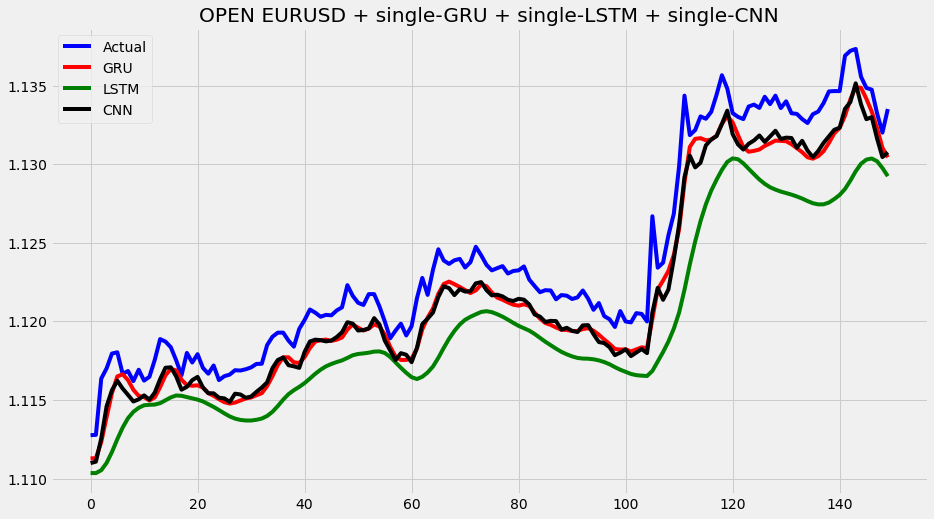

In [ ]:
plt.figure(figsize=(14,8))

plt.plot(ytest_rescale[(len(ytest_rescale)-150):,0],'blue')
plt.plot(Test_Pred_MinMaxGRU[(len(Test_Pred_MinMaxGRU)-150):,0],'red')
plt.plot(Test_Pred_MinMaxLSTM[(len(Test_Pred_MinMaxLSTM)-150):,0],'green')
plt.plot(Test_Pred_MinMaxCNN[(len(Test_Pred_MinMaxCNN)-150):,0],'black')
#plt.plot(Test_Pred_lstm[(len(Test_Pred_lstm)-90):,3],'g')
plt.legend(('Actual', 'GRU', 'LSTM', 'CNN'), loc='upper left')
plt.title("OPEN EURUSD + single-GRU + single-LSTM + single-CNN")
plt.show()

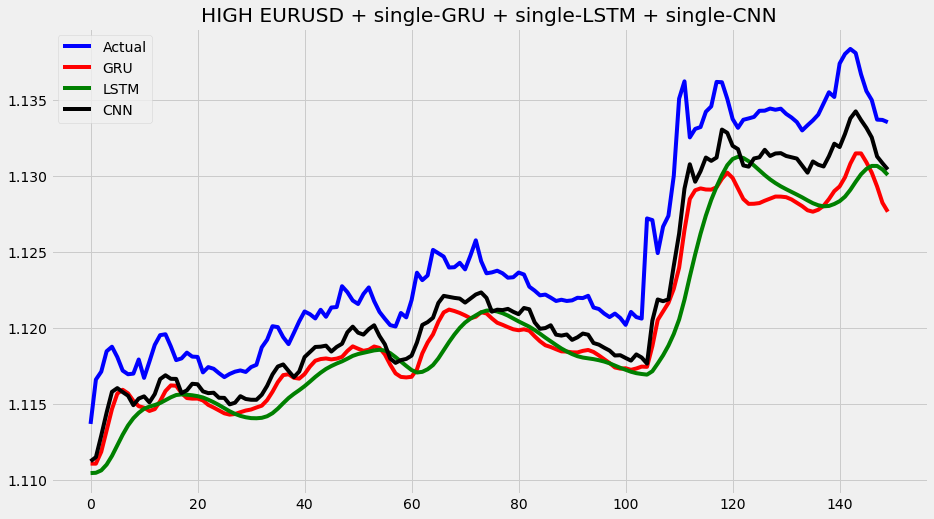

In [ ]:
plt.figure(figsize=(14,8))

plt.plot(ytest_rescale[(len(ytest_rescale)-150):,1],'blue')
plt.plot(Test_Pred_MinMaxGRU[(len(Test_Pred_MinMaxGRU)-150):,1],'red')
plt.plot(Test_Pred_MinMaxLSTM[(len(Test_Pred_MinMaxLSTM)-150):,1],'green')
plt.plot(Test_Pred_MinMaxCNN[(len(Test_Pred_MinMaxCNN)-150):,1],'black')
plt.legend(('Actual', 'GRU', 'LSTM', 'CNN'), loc='upper left')
plt.title("HIGH EURUSD + single-GRU + single-LSTM + single-CNN")
plt.show()

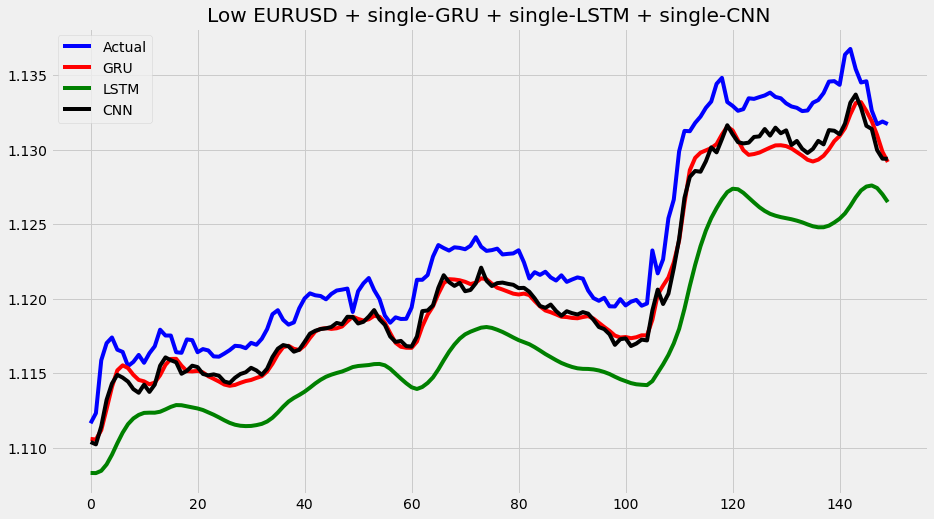

In [ ]:
plt.figure(figsize=(14,8))

plt.plot(ytest_rescale[(len(ytest_rescale)-150):,2],'blue')
plt.plot(Test_Pred_MinMaxGRU[(len(Test_Pred_MinMaxGRU)-150):,2],'red')
plt.plot(Test_Pred_MinMaxLSTM[(len(Test_Pred_MinMaxLSTM)-150):,2],'green')
plt.plot(Test_Pred_MinMaxCNN[(len(Test_Pred_MinMaxCNN)-150):,2],'black')
plt.legend(('Actual', 'GRU', 'LSTM', 'CNN'), loc='upper left')
plt.title("Low EURUSD + single-GRU + single-LSTM + single-CNN")
plt.show()

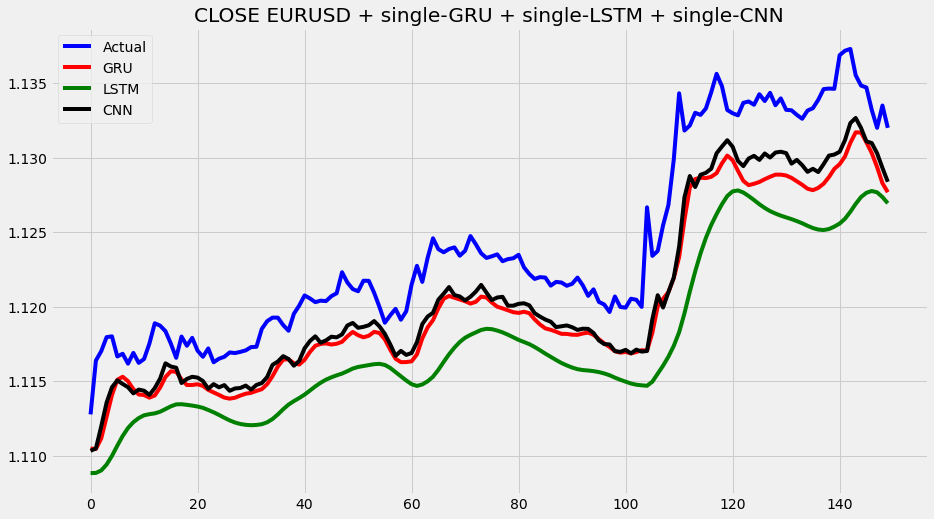

In [ ]:
plt.figure(figsize=(14,8))

plt.plot(ytest_rescale[(len(ytest_rescale)-150):,3],'blue')
plt.plot(Test_Pred_MinMaxGRU[(len(Test_Pred_MinMaxGRU)-150):,3],'red')
plt.plot(Test_Pred_MinMaxLSTM[(len(Test_Pred_MinMaxLSTM)-150):,3],'green')
plt.plot(Test_Pred_MinMaxCNN[(len(Test_Pred_MinMaxCNN)-150):,3],'black')
plt.legend(('Actual', 'GRU', 'LSTM', 'CNN'), loc='upper left')
plt.title("CLOSE EURUSD + single-GRU + single-LSTM + single-CNN")
plt.show()